### 1. Data Exploration and Preprocessing

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, classification_report
from sklearn.metrics import auc 
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import xgboost as xgb
import shap
shap.initjs()

df = pd.read_csv("creditcard.csv")
print("Dataset Shape:", df.shape)
print("Summary Statistics:")
print(df.describe())

Dataset Shape: (284807, 31)
Summary Statistics:
                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.487313e-15 -5.556467e-16  1.213481e-16 -2.406331e-

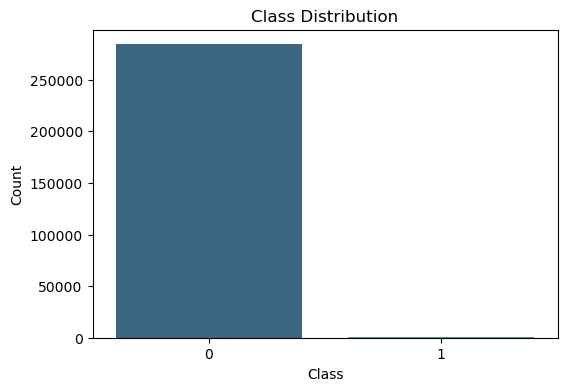

In [2]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=df, hue='Class', palette="viridis", legend=False)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [3]:
# Check for Missing Values
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)

# Step 2: Data Preprocessing
if missing_values.sum() > 0:
    df.fillna(df.mean(), inplace=True)
    print("Missing values handled by replacing with column mean.")

Missing Values:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


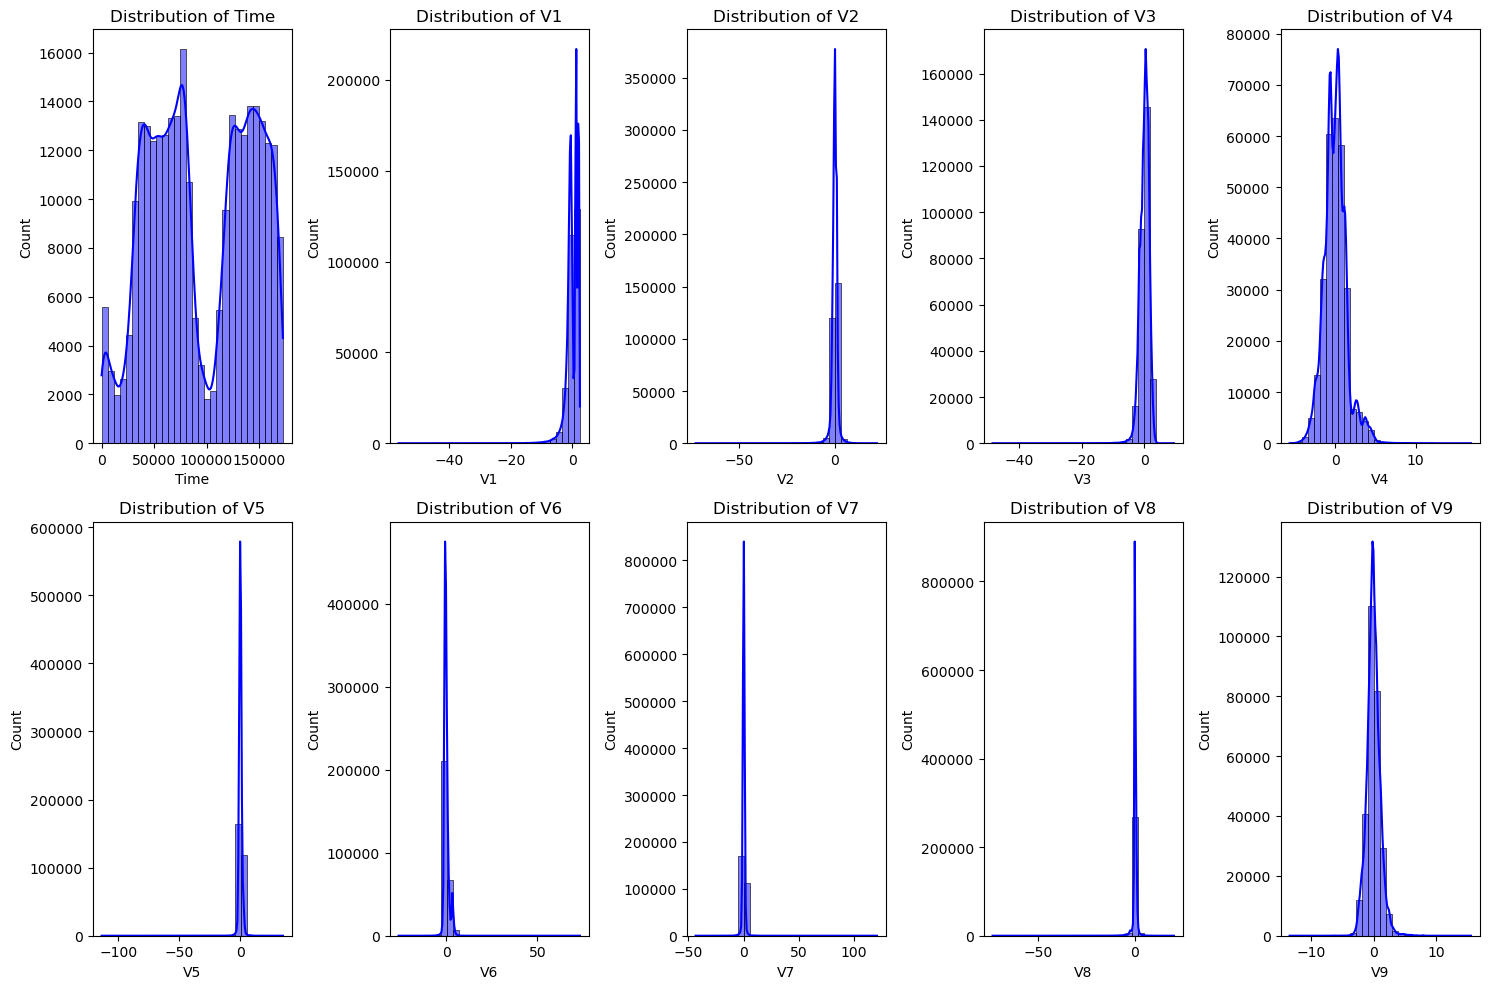

In [4]:
X = df.drop(columns=['Class'])
y = df['Class']

# Feature Distribution
plt.figure(figsize=(15, 10))
for i, col in enumerate(X.columns[:10], 1):
    plt.subplot(2, 5, i)
    sns.histplot(X[col], kde=True, bins=30, color='blue')
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

Original Class Distribution:
 Class
0    284315
1       492
Name: count, dtype: int64


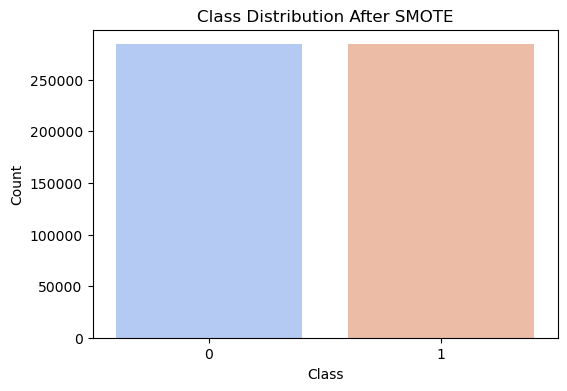

Shape of Resampled Data: (568630, 30)
Resampled Class Distribution:
 Class
0    284315
1    284315
Name: count, dtype: int64


In [18]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Original Class Distribution:\n", y.value_counts())

# Apply SMOTE for balancing
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

plt.figure(figsize=(6, 4))
sns.countplot(x=y_resampled, hue=y_resampled, palette="coolwarm", legend=False)
plt.title("Class Distribution After SMOTE")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

print("Shape of Resampled Data:", X_resampled.shape)
print("Resampled Class Distribution:\n", pd.Series(y_resampled).value_counts())

### 2. Model Development (Supervised)

Logistic Regression Performance:
Accuracy: 0.9500729824314581
Recall: 0.9247226902555462
Precision: 0.9743139285450108
F1-Score: 0.9488707992652091
ROC AUC: 0.989972291757129
              precision    recall  f1-score   support

           0       0.93      0.98      0.95     56750
           1       0.97      0.92      0.95     56976

    accuracy                           0.95    113726
   macro avg       0.95      0.95      0.95    113726
weighted avg       0.95      0.95      0.95    113726



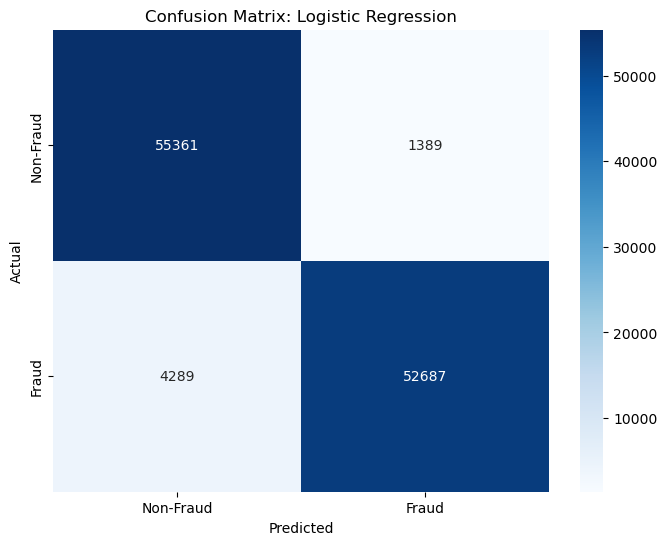

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Baseline Model: Logistic Regression
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)

# Performance Metrics for Logistic Regression
print("Logistic Regression Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("Recall:", recall_score(y_test, y_pred_log))
print("Precision:", precision_score(y_test, y_pred_log))
print("F1-Score:", f1_score(y_test, y_pred_log))
print("ROC AUC:", roc_auc_score(y_test, log_model.predict_proba(X_test)[:, 1]))
print(classification_report(y_test, y_pred_log))

# Confusion Matrix for Logistic Regression
conf_matrix_log = confusion_matrix(y_test, y_pred_log)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_log, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title("Confusion Matrix: Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

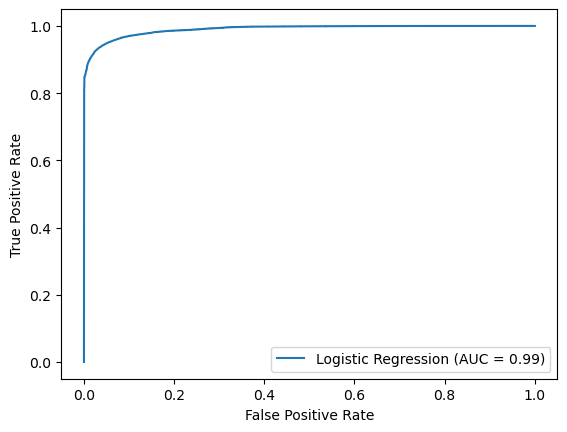

In [20]:
# ROC-AUC Curve for Logistic Regression
fpr, tpr, _ = roc_curve(y_test, log_model.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label="Logistic Regression (AUC = {:.2f})".format(roc_auc_score(y_test, log_model.predict_proba(X_test)[:, 1])))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

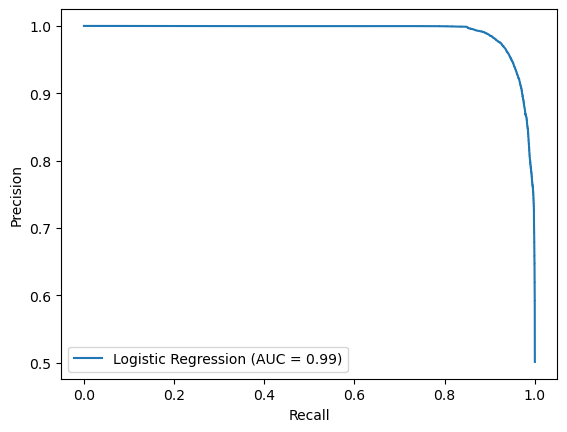

In [21]:
# PR-AUC Curve for Logistic Regression
precision, recall, _ = precision_recall_curve(y_test, log_model.predict_proba(X_test)[:, 1])
plt.plot(recall, precision, label="Logistic Regression (AUC = {:.2f})".format(auc(recall, precision)))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

XGBoost Performance:
Accuracy: 0.9943988182121942
Recall: 0.9945766638584668
Precision: 0.994245109220107
F1-Score: 0.9944108589027033
ROC AUC: 0.9998032962638569
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     56750
           1       0.99      0.99      0.99     56976

    accuracy                           0.99    113726
   macro avg       0.99      0.99      0.99    113726
weighted avg       0.99      0.99      0.99    113726



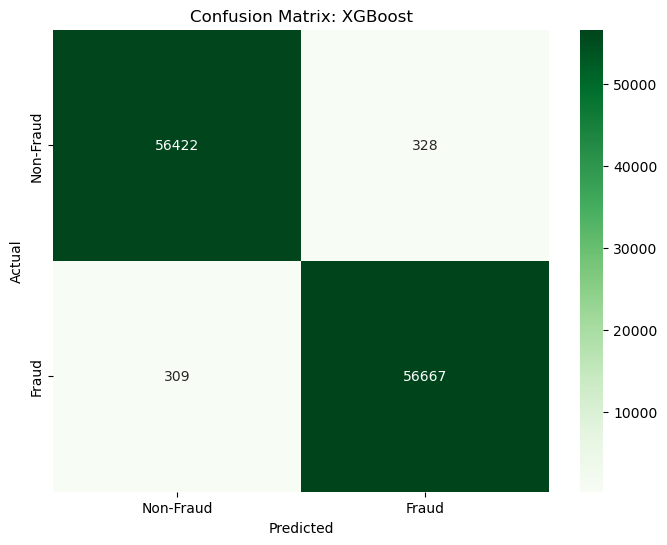

In [22]:
xgb_model = XGBClassifier(
    eval_metric='logloss',
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# Predict and Evaluate XGBoost
y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Recall:", recall_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb))
print("F1-Score:", f1_score(y_test, y_pred_xgb))
print("ROC AUC:", roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1]))
print(classification_report(y_test, y_pred_xgb))

# Confusion Matrix for XGBoost
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Greens', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title("Confusion Matrix: XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

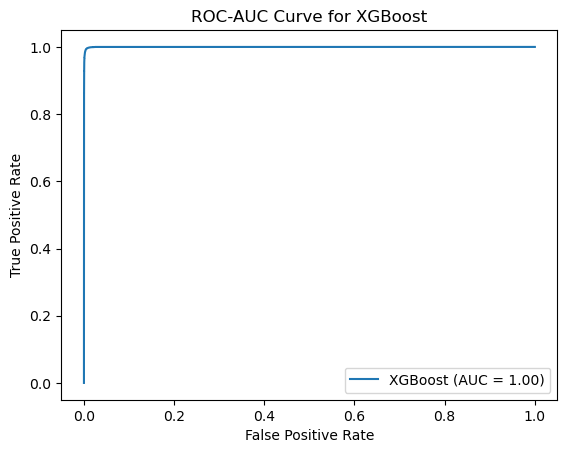

In [23]:
# ROC-AUC Curve for XGBoost
fpr, tpr, _ = roc_curve(y_test, xgb_model.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label="XGBoost (AUC = {:.2f})".format(roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1])))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("ROC-AUC Curve for XGBoost")
plt.show()

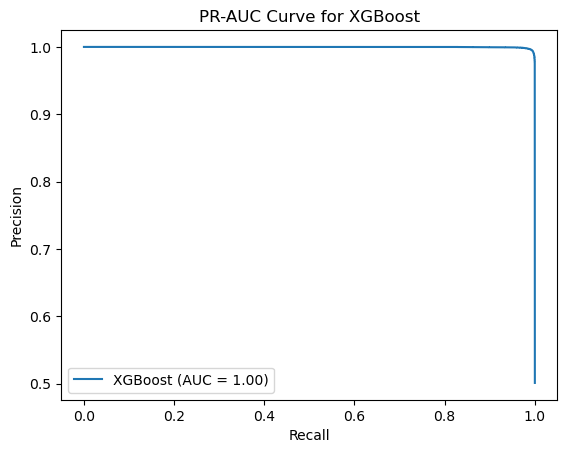

In [24]:
# PR-AUC Curve for XGBoost
precision, recall, _ = precision_recall_curve(y_test, xgb_model.predict_proba(X_test)[:, 1])
plt.plot(recall, precision, label="XGBoost (AUC = {:.2f})".format(auc(recall, precision)))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.title("PR-AUC Curve for XGBoost")
plt.show()

In [25]:
# Hyperparameter Distribution for XGBoost
param_dist = {
    'n_estimators': randint(100, 200),
    'max_depth': randint(3, 7),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3)
}

# RandomizedSearchCV for XGBoost
random_search = RandomizedSearchCV(
    XGBClassifier(eval_metric='logloss', random_state=42),
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    scoring='recall',
    random_state=42,
    n_jobs=-1
)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Print the best parameters found
print("Best Hyperparameters from Randomized Search:", random_search.best_params_)

Best Hyperparameters from Randomized Search: {'colsample_bytree': 0.8123620356542087, 'learning_rate': 0.20014286128198325, 'max_depth': 5, 'n_estimators': 171, 'subsample': 0.8795975452591109}


Optimized XGBoost Performance:
Accuracy: 0.9995691398624765
Recall: 1.0
Precision: 0.9991407277509864
F1-Score: 0.9995701792089543
ROC AUC: 0.9999883543206073
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56750
           1       1.00      1.00      1.00     56976

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726



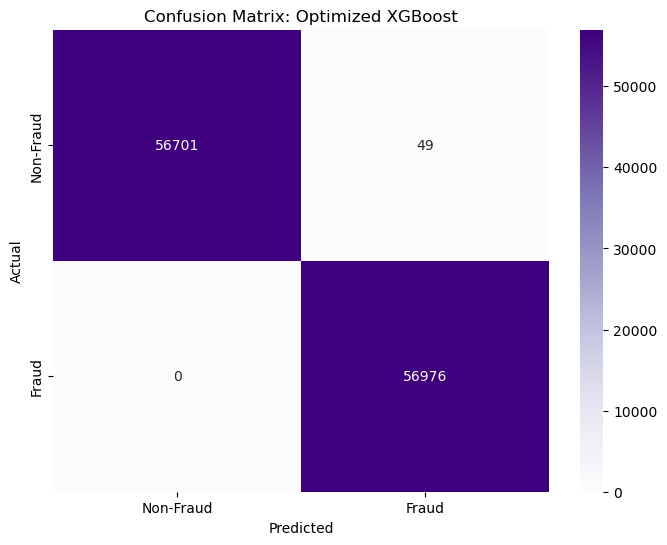

In [26]:
best_xgb_random_model = random_search.best_estimator_
y_pred_best_xgb_random = best_xgb_random_model.predict(X_test)

# Performance Metrics for the Best Model
print("Optimized XGBoost Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_best_xgb_random))
print("Recall:", recall_score(y_test, y_pred_best_xgb_random))
print("Precision:", precision_score(y_test, y_pred_best_xgb_random))
print("F1-Score:", f1_score(y_test, y_pred_best_xgb_random))
print("ROC AUC:", roc_auc_score(y_test, best_xgb_random_model.predict_proba(X_test)[:, 1]))
print(classification_report(y_test, y_pred_best_xgb_random))

# Confusion Matrix for Optimized XGBoost
conf_matrix_best_xgb_random = confusion_matrix(y_test, y_pred_best_xgb_random)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_best_xgb_random, annot=True, fmt='d', cmap='Purples', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title("Confusion Matrix: Optimized XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### 3. Model Development (Unsupervised)

In [27]:
# Unsupervised Model: Isolation Forest
iso_forest = IsolationForest(contamination=0.01, random_state=42)
iso_forest.fit(X_scaled)

y_pred_iso = iso_forest.predict(X_scaled)
y_pred_iso = [1 if x == -1 else 0 for x in y_pred_iso]

# Performance Metrics
print("Unsupervised Model Performance:")
print("Detected Anomalies:", sum(y_pred_iso))

Unsupervised Model Performance:
Detected Anomalies: 2849


Accuracy: 0.9902986935012131
Recall: 0.5873983739837398
Precision: 0.10143910143910144
F1-Score: 0.1730020951810835


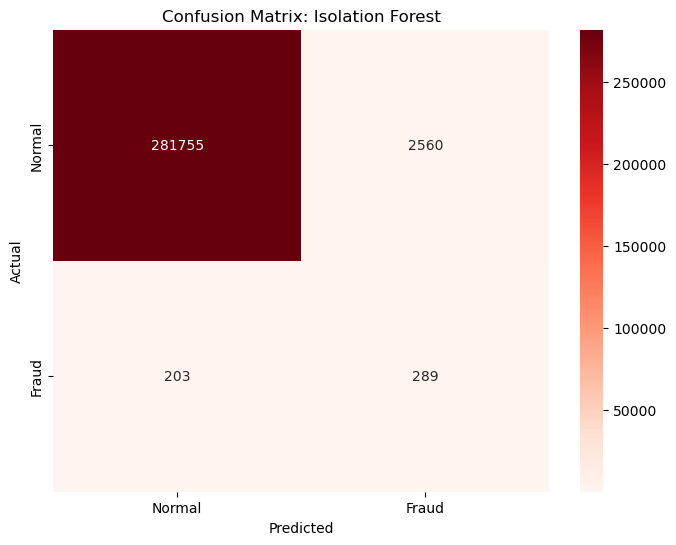

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    284315
           1       0.10      0.59      0.17       492

    accuracy                           0.99    284807
   macro avg       0.55      0.79      0.58    284807
weighted avg       1.00      0.99      0.99    284807



In [28]:
# Evaluate the model
print("Accuracy:", accuracy_score(y, y_pred_iso))
print("Recall:", recall_score(y, y_pred_iso))
print("Precision:", precision_score(y, y_pred_iso))
print("F1-Score:", f1_score(y, y_pred_iso))

# Confusion Matrix for Isolation Forest
conf_matrix_iso = confusion_matrix(y, y_pred_iso)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_iso, annot=True, fmt='d', cmap='Reds', xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
plt.title("Confusion Matrix: Isolation Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y, y_pred_iso))

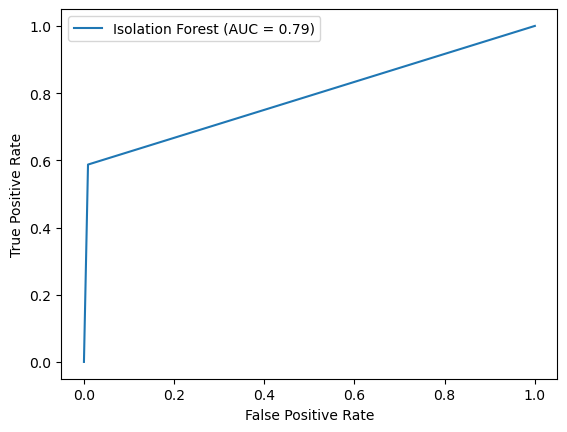

In [29]:
# ROC-AUC Curve for Isolation Forest
fpr, tpr, _ = roc_curve(y, y_pred_iso)
plt.plot(fpr, tpr, label="Isolation Forest (AUC = {:.2f})".format(roc_auc_score(y, y_pred_iso)))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

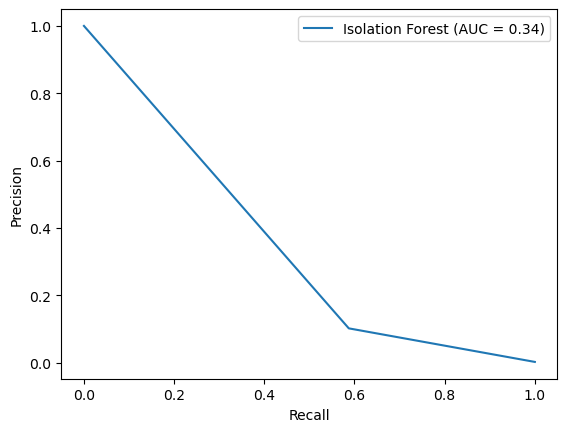

In [30]:
# PR-AUC Curve for Isolation Forest
precision, recall, _ = precision_recall_curve(y, y_pred_iso)
plt.plot(recall, precision, label="Isolation Forest (AUC = {:.2f})".format(auc(recall, precision)))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

### Insights

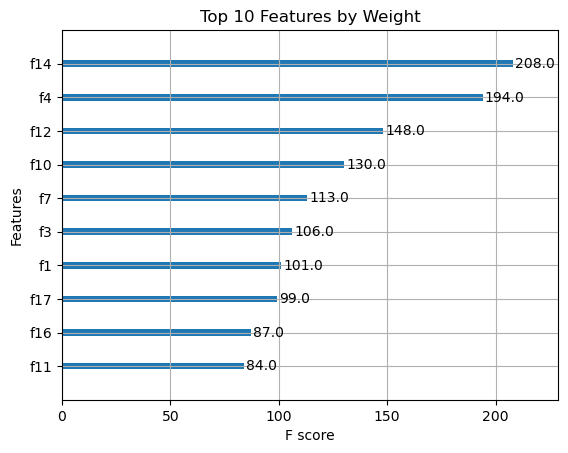

In [34]:
xgb.plot_importance(xgb_model, importance_type='weight', max_num_features=10, title='Top 10 Features by Weight')
plt.show()

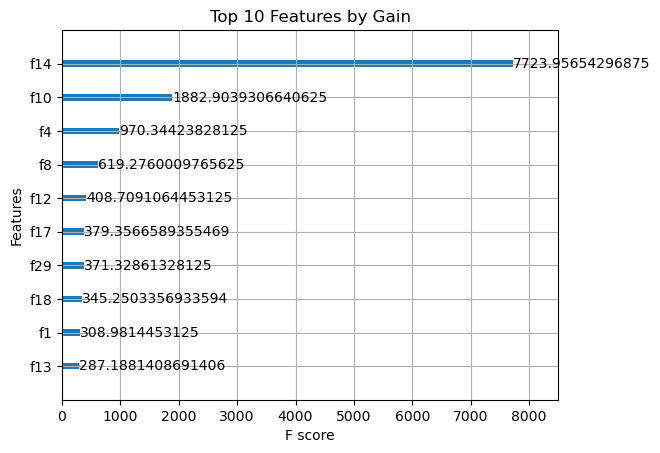

In [35]:
xgb.plot_importance(xgb_model, importance_type='gain', max_num_features=10, title='Top 10 Features by Gain')
plt.show()

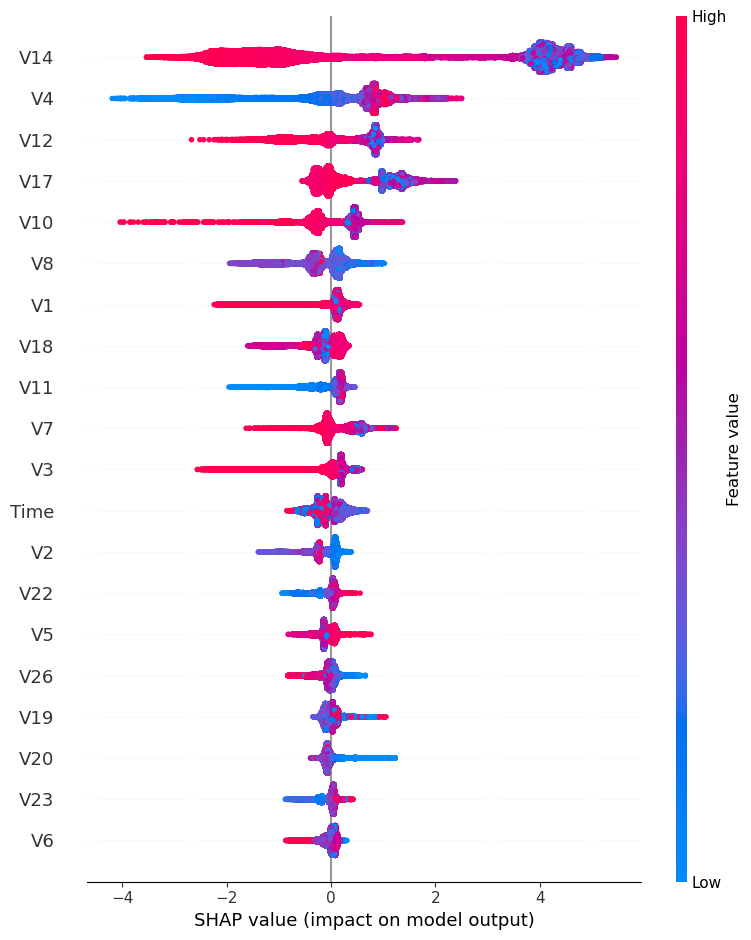

In [36]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=df.columns[:-1])
shap.force_plot(explainer.expected_value, shap_values[0], X_test[0])